# Importing Required Packages

In [ ]:
import numpy as np
import pandas as pd
#import hyperopt
from catboost import Pool, CatBoostClassifier, cv # for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns # For data visualization 
import matplotlib.pyplot as plt # For plotting graphs 
%matplotlib inline 
#from dfply import *
import os
import warnings
from pandas.plotting import scatter_matrix

In [ ]:
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})

### DATA IMPORTATION

In [ ]:
train = pd.read_csv("train_values.csv", low_memory=False)
test = pd.read_csv("test_values.csv", low_memory=False)
train_label = pd.read_csv("train_labels.csv", low_memory=False)

In [ ]:
train = pd.merge(train, train_label, on='row_id') # Merging the dependent and independent variables together
train.head()

### Making a  copy of the training and testing dataset.

In [75]:
train_original = train.copy() 
train1 = train
test_original = test.copy()

# Understanding the Data

In [76]:
train.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted'],
      dtype='object')

In [77]:
train.dtypes #Checking the data types of the available data

row_id                              int64
loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                          int64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                         bool
accepted                            int64
dtype: object

#### computing correlation of the numeric features(columns)

In [78]:
num = [ 'loan_amount', 'applicant_income', 
          'ffiecmedian_family_income','population',
           'minority_population_pct','ffiecmedian_family_income','tract_to_msa_md_income_pct',
          'number_of_owner-occupied_units','number_of_1_to_4_family_units']
train[num].corr()

,loan_amount,applicant_income,ffiecmedian_family_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units
loan_amount,1.000000,0.483951,0.105924,0.000100,0.007227,0.105924,0.043811,-0.013660,-0.036644
applicant_income,0.483951,1.000000,0.114988,-0.006948,-0.053795,0.114988,0.102667,0.004541,-0.019748
ffiecmedian_family_income,0.105924,0.114988,1.000000,-0.014377,0.021059,1.000000,-0.054500,-0.021390,-0.148235
population,0.000100,-0.006948,-0.014377,1.000000,0.087383,-0.014377,0.149677,0.858732,0.816952
minority_population_pct,0.007227,-0.053795,0.021059,0.087383,1.000000,0.021059,-0.442800,-0.214410,-0.157976
ffiecmedian_family_income,0.105924,0.114988,1.000000,-0.014377,0.021059,1.000000,-0.054500,-0.021390,-0.148235
tract_to_msa_md_income_pct,0.043811,0.102667,-0.054500,0.149677,-0.442800,-0.054500,1.000000,0.360774,0.210613
number_of_owner-occupied_units,-0.013660,0.004541,-0.021390,0.858732,-0.214410,-0.021390,0.360774,1.000000,0.887591
number_of_1_to_4_family_units,-0.036644,-0.019748,-0.148235,0.816952,-0.157976,-0.148235,0.210613,0.887591,1.000000


#### CHECKING THE SHAPE OF THE DATASETS PROVIDED

In [79]:
train.shape, test.shape   

((500000, 23), (500000, 22))

We have 500,000 rows and 23 columns(including train labels) in the train dataset and 500,000 rows and 22 columns in test dataset.

### Missing Value and Outliers Treatment

In [80]:
train.isnull().sum()

row_id                                0
loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval                           0
msa_md                                0
state_code                            0
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                  39948
population                        22465
minority_population_pct           22466
ffiecmedian_family_income         22440
tract_to_msa_md_income_pct        22514
number_of_owner-occupied_units    22565
number_of_1_to_4_family_units     22530
lender                                0
co_applicant                          0
accepted                              0
dtype: int64

### Percentage of Missing Values

In [89]:
(train.isnull().sum()* 100)/500000

row_id                            0.0
loan_type                         0.0
property_type                     0.0
loan_purpose                      0.0
occupancy                         0.0
loan_amount                       0.0
preapproval                       0.0
msa_md                            0.0
state_code                        0.0
county_code                       0.0
applicant_ethnicity               0.0
applicant_race                    0.0
applicant_sex                     0.0
applicant_income                  0.0
population                        0.0
minority_population_pct           0.0
ffiecmedian_family_income         0.0
tract_to_msa_md_income_pct        0.0
number_of_owner-occupied_units    0.0
number_of_1_to_4_family_units     0.0
lender                            0.0
co_applicant                      0.0
accepted                          0.0
loan_income_ratio                 0.0
dtype: float64

There are missing values in applicant_income, population, minority_population_pct, ffiecmedian_family_income, tract_to_msa_md_income_pct, number_of_owner-occupied_units and number_of_1_to_4_family_units features.
With a maximum percentage of 8%.
We will treat the missing values in all the features one by one. 

Also replacing -1 with nas in na's in msa_md, state_code, county_code

### Replacing -1 with na's in msa_md, state_code, county_code

In [90]:
def missing_val(loan):
    loan['msa_md'] = loan['msa_md'].replace(-1, np.nan)
    loan['state_code'] = loan['state_code'].replace(-1, np.nan)
    loan['county_code'] = loan['county_code'].replace(-1, np.nan)
    return loan

### Replacing all nas with 0

In [91]:
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [92]:
train.isnull().sum()

row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
accepted                          0
loan_income_ratio                 0
dtype: int64

In [93]:
#train = train.fillna(train.mode().iloc[0])
#test = test.fillna(test.mode().iloc[0])

In [94]:
#test.isnull().sum()

# Data Cleaning and Manipulation

In [95]:
# Derived Metrics
train['loan_income_ratio']= (train['loan_amount']/train['applicant_income'])
test['loan_income_ratio']= (test['loan_amount']/test['applicant_income'])

In [96]:
encode = LabelEncoder()
test['co_applicant'] = encode.fit_transform(test['co_applicant'].astype('str'))
train['co_applicant'] = encode.fit_transform(train['co_applicant'].astype('str'))

# FEATURES ENGINERRING

Converting all then numerical features into bins depending on the minum and maximum

### TRAIN

In [97]:
#Income
bins = [0,1500,4000,6000,10139] 
group = ['Low','Average','High', 'Very high'] 
train['Income_bin'] = pd.cut(train['applicant_income'],bins,labels = group)

#loan_amount
bins = [0,1500,4000,6000,1000000] 
group = ['Low','Average','High', 'Very high'] 

train['loan_amount_bin'] = pd.cut(train['loan_amount'],bins,labels=group)

#population 
bins=[0,8000,15000,25000,40000] 
group=['Low','Average','High', 'Very high'] 

train['population_pop_bin']=pd.cut(train['population'],bins,labels=group)

#minority_population_pct
bins=[0,15,30,60,1000] 
group=['Low','Average','High', 'Very high'] 

train['min_pop_bin']=pd.cut(train['minority_population_pct'],bins,labels=group)

#number_of_owner-occupied_units
bins=[0,500, 2000,3500,5000,10000] 
group=['Low','Average','Good','High', 'Very high'] 

train['num_own_bin']=pd.cut(train['number_of_owner-occupied_units'],bins,labels=group)

#num =['applicant_income','loan_amount','population',
 #     'minority_population_pct','number_of_owner-occupied_units']

### TEST

In [98]:
#Income
bins=[0,1500,4000,6000,100000] 
group=['Low','Average','High', 'Very high'] 
test['Income_bin']=pd.cut(test['applicant_income'],bins,labels=group)

#loan_amount
bins=[0,1500,4000,6000,1000000] 
group=['Low','Average','High', 'Very high'] 

test['loan_amount_bin']=pd.cut(test['loan_amount'],bins,labels=group)

#population 
bins=[0,8000,15000,25000,40000] 
group=['Low','Average','High', 'Very high'] 

test['population_pop_bin']=pd.cut(test['population'],bins,labels=group)

#minority_population_pct
bins=[0,15,30,60,1000] 
group=['Low','Average','High', 'Very high'] 

test['min_pop_bin']=pd.cut(test['minority_population_pct'],bins,labels=group)

#number_of_owner-occupied_units
bins=[0,500, 2000,3500,5000,10000] 
group=['Low','Average','Good','High', 'Very high'] 

test['num_own_bin']=pd.cut(test['number_of_owner-occupied_units'],bins,labels=group)

#num = ['applicant_income','loan_amount','population',
 #     'minority_population_pct','number_of_owner-occupied_units']

In [99]:
#test = test.drop(['row_id','applicant_income','loan_amount','population',
  #    'minority_population_pct','number_of_owner-occupied_units'],axis=1)

In [100]:
#train = train.drop(['row_id','applicant_income','loan_amount','population',
   #   'minority_population_pct','number_of_owner-occupied_units'],axis=1)

In [101]:
def data_manage(loan):
    
    # Derived Metrics
    
    #loan['loan_income_ratio']= loan['loan_amount']/loan['applicant_income']
    
    # set variable types (Categorical)
    
    loan['preapproval'] = loan['preapproval'].astype('category')
    loan['applicant_race'] = loan['applicant_race'].astype('category')
    loan['applicant_sex'] = loan['applicant_sex'].astype('category')
    loan['loan_purpose'] = loan['loan_purpose'].astype('category')
    loan['occupancy'] = loan['occupancy'].astype('category')
    loan['property_type'] = loan['property_type'].astype('category')
    loan['loan_type'] = loan['loan_type'].astype('category')
    loan['applicant_ethnicity'] = loan['applicant_ethnicity'].astype('category')
    loan['msa_md'] = loan['msa_md'].astype('category')
    loan['state_code'] = loan['state_code'].astype('category')
    loan['county_code'] = loan['county_code'].astype('category')
    loan['accepted'] = loan['accepted'].astype('category')
    ############
    loan['loan_amount_bin'] = loan['loan_amount_bin'].astype('category')
    loan['Income_bin'] = loan['Income_bin'].astype('category')
    loan['population_pop_bin'] = loan['population_pop_bin'].astype('category')
    loan['min_pop_bin'] = loan['min_pop_bin'].astype('category')
    loan['num_own_bin'] = loan['num_own_bin'].astype('category')
    
     # set variable types (numeric)
        
    
    loan['ffiecmedian_family_income'] = loan['ffiecmedian_family_income'].convert_objects(convert_numeric=True)
    loan['tract_to_msa_md_income_pct'] = loan['tract_to_msa_md_income_pct'].convert_objects(convert_numeric=True)
    loan['number_of_1_to_4_family_units'] = loan['number_of_1_to_4_family_units'].convert_objects(convert_numeric=True)
    loan['loan_income_ratio'] = loan['loan_income_ratio'].convert_objects(convert_numeric=True)
    
    return loan

In [102]:
train = data_manage(train)

In [103]:
def data_manage2(loan):
    
    # Derived Metrics
    
    #loan['loan_income_ratio']= loan['loan_amount']/loan['applicant_income']
    
    # set variable types (Categorical)
    
    loan['preapproval'] = loan['preapproval'].astype('category')
    loan['applicant_race'] = loan['applicant_race'].astype('category')
    loan['applicant_sex'] = loan['applicant_sex'].astype('category')
    loan['loan_purpose'] = loan['loan_purpose'].astype('category')
    loan['occupancy'] = loan['occupancy'].astype('category')
    loan['property_type'] = loan['property_type'].astype('category')
    loan['loan_type'] = loan['loan_type'].astype('category')
    loan['applicant_ethnicity'] = loan['applicant_ethnicity'].astype('category')
    loan['msa_md'] = loan['msa_md'].astype('category')
    loan['state_code'] = loan['state_code'].astype('category')
    loan['county_code'] = loan['county_code'].astype('category')
    #loan['accepted'] = loan['accepted'].astype('category')
    loan['loan_amount_bin'] = loan['loan_amount_bin'].astype('category')
    loan['Income_bin'] = loan['Income_bin'].astype('category')
    loan['population_pop_bin'] = loan['population_pop_bin'].astype('category')
    loan['min_pop_bin'] = loan['min_pop_bin'].astype('category')
    loan['num_own_bin'] = loan['num_own_bin'].astype('category')
    # set variable types (numeric)
        

        
    loan['ffiecmedian_family_income'] = loan['ffiecmedian_family_income'].convert_objects(convert_numeric=True)
    loan['tract_to_msa_md_income_pct'] = loan['tract_to_msa_md_income_pct'].convert_objects(convert_numeric=True)
    loan['number_of_1_to_4_family_units'] = loan['number_of_1_to_4_family_units'].convert_objects(convert_numeric=True)
    #loan['loan_income_ratio'] = loan['loan_income_ratio'].convert_objects(convert_numeric=True)
    
    return loan

In [104]:
test = data_manage2(test)

In [105]:
train = train.fillna(train.mode().iloc[0])
test = test.fillna(test.mode().iloc[0])

In [106]:
train.isnull().sum()

row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
accepted                          0
loan_income_ratio                 0
Income_bin                        0
loan_amount_bin                   0
population_pop_bin                0
min_pop_bin                 

In [107]:
train = train.drop(['row_id'], axis=1)
test = test.drop(['row_id'], axis=1)

In [108]:
y = train.accepted
X = train.drop('accepted',axis=1) # Dropping the deepending variable from the features to be trained


### Univariate Analysis

In this section, we will do univariate analysis. which is the simplest form of analyzing data where we examine each variable individually.

For categorical features, i will use frequency table or bar plots which will calculate the number of each category in a particular variable.

For numerical features, probability density plots will be used to look at the distribution of the variable.

### Target Variable(accepted )

In [109]:
 train1['accepted'].value_counts()

1    250114
0    249886
Name: accepted, dtype: int64

we set Normalize to True to print proportions instead of number

In [110]:
 train1['accepted'].value_counts(normalize = True)

1    0.500228
0    0.499772
Name: accepted, dtype: float64

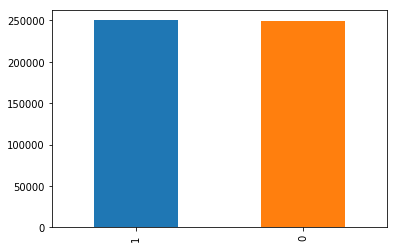

In [111]:
 train1['accepted'].value_counts().plot.bar()

Out of the total loan applied for the year, 250114 (around 50%) was approved and the others was rejected(approximatelty 50%). Which shows that we have a balance data.

### Categorical(Independent Variable)

Visualizing each variable separately.

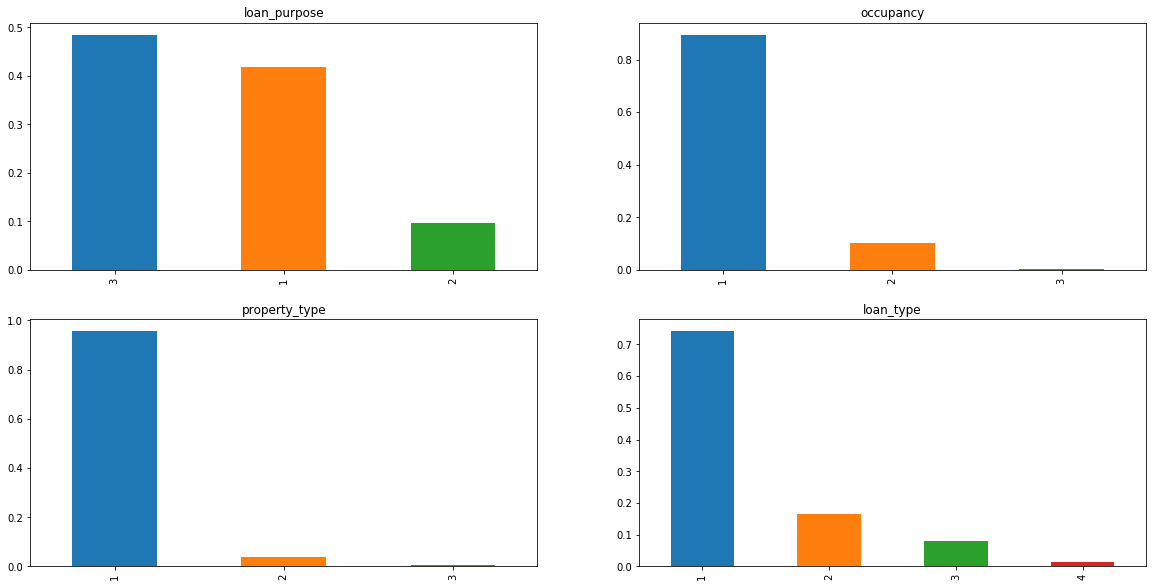

In [112]:
plt.figure(1)
plt.subplot(221)
train1['loan_purpose'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'loan_purpose') 

plt.subplot(222)
train1['occupancy'].value_counts(normalize=True).plot.bar(title= 'occupancy') 

plt.subplot(223) 
train1['property_type'].value_counts(normalize=True).plot.bar(title= 'property_type') 

plt.subplot(224) 
train1['loan_type'].value_counts(normalize=True).plot.bar(title= 'loan_type') 
plt.show()

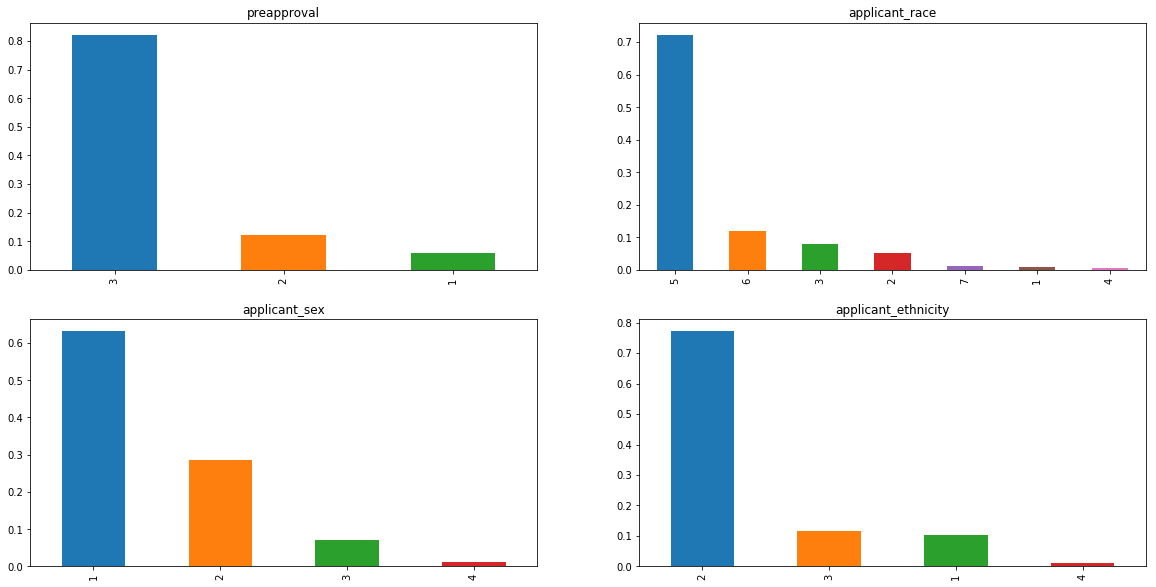

In [113]:
plt.figure(1)
plt.subplot(221)
train1['preapproval'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'preapproval') 

plt.subplot(222)
train1['applicant_race'].value_counts(normalize=True).plot.bar(title= 'applicant_race') 

plt.subplot(223) 
train1['applicant_sex'].value_counts(normalize=True).plot.bar(title= 'applicant_sex') 

plt.subplot(224) 
train1['applicant_ethnicity'].value_counts(normalize=True).plot.bar(title= 'applicant_ethnicity') 
plt.show()

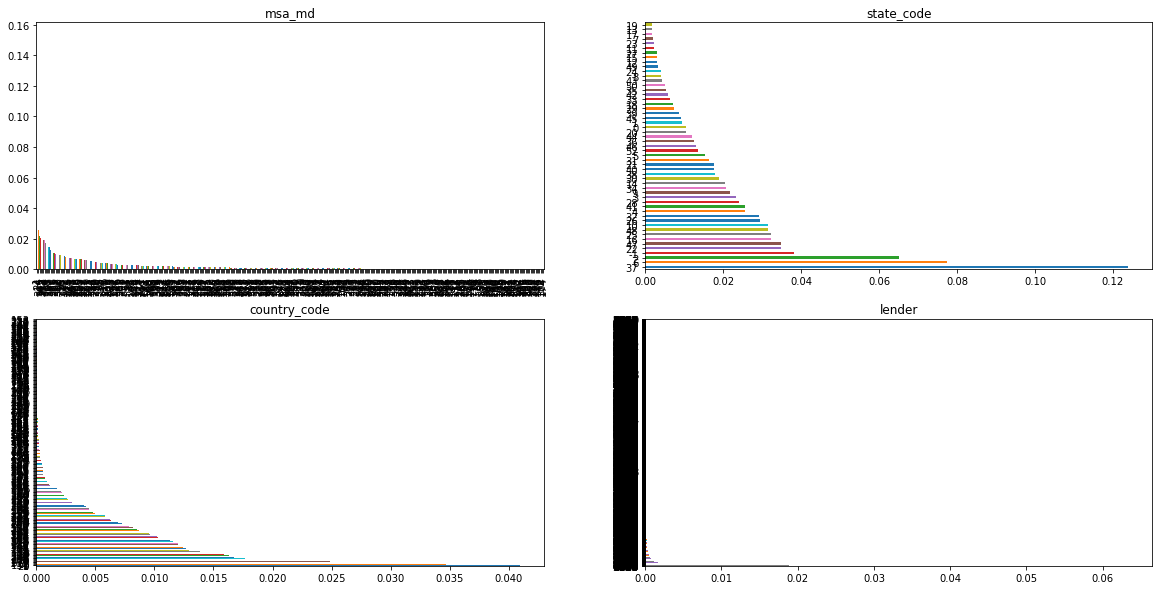

In [114]:
plt.figure(1)
plt.subplot(221)
train1['msa_md'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'msa_md') 

plt.subplot(222)
train1['state_code'].value_counts(normalize=True).plot.barh(title= 'state_code') 

plt.subplot(223) 
train1['county_code'].value_counts(normalize=True).plot.barh(title= 'country_code') 

plt.subplot(224) 
train1['lender'].value_counts(normalize=True).plot.barh(title= 'lender') 
plt.show()

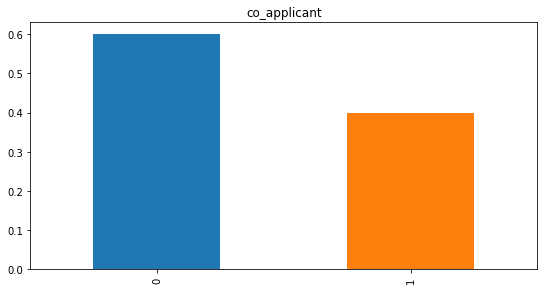

In [115]:
plt.figure(1)
plt.subplot(221)
train1['co_applicant'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'co_applicant') 
plt.show()

### Numerical

In [116]:
train1 = train1.dropna()
train1.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,number_of_1_to_4_family_units,lender,co_applicant,accepted,loan_income_ratio,Income_bin,loan_amount_bin,population_pop_bin,min_pop_bin,num_own_bin
0,0,3,1,1,1,70.0,3,18,37,246,...,2642.0,4536,0,1,2.916667,Low,Low,Low,High,Average
1,1,1,1,3,1,178.0,3,369,52,299,...,2108.0,2458,0,0,3.122807,Low,Low,Low,Average,Average
2,2,2,1,3,1,163.0,3,16,10,306,...,1048.0,5710,0,1,2.432836,Low,Low,Low,Very high,Average
3,3,1,1,1,1,155.0,1,305,47,180,...,2299.0,5888,1,1,1.476190,Low,Low,Low,Low,Good
4,4,1,1,1,1,305.0,3,24,37,20,...,1847.0,289,0,1,4.295775,Low,Low,Low,Very high,Average


In [117]:
#plt.figure(1) 
#plt.subplot(124)
#sns.distplot(train['loan_amount']); 
#plt.subplot(125)
#train['loan_amount'].plot.box(figsize=(16,5)) 
#plt.show()

In [118]:
#plt.figure(1) 
#plt.subplot(121)
#sns.distplot(train1['applicant_income']); 
#plt.subplot(122)
#train1['applicant_income'].plot.box(figsize=(16,5)) 
#plt.show()

In [119]:
#plt.figure(1) 
#plt.subplot(121)
#sns.distplot(train1['population']); 
#plt.subplot(122)
#train1['population'].plot.box(figsize=(16,5)) 
#plt.show()

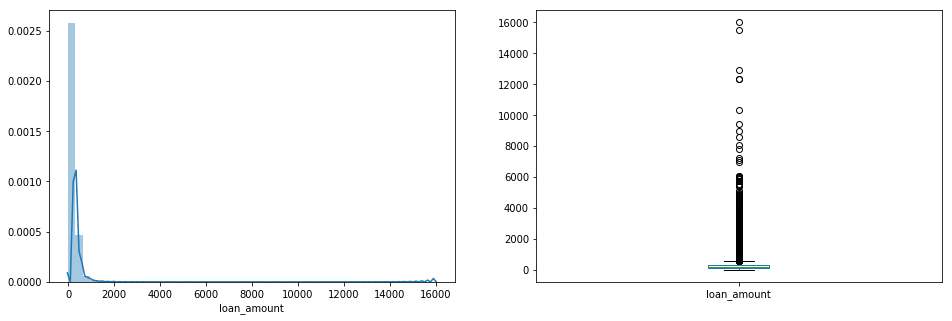

In [120]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train1['loan_amount']); 
plt.subplot(122)
train1['loan_amount'].plot.box(figsize=(16,5)) 
plt.show()

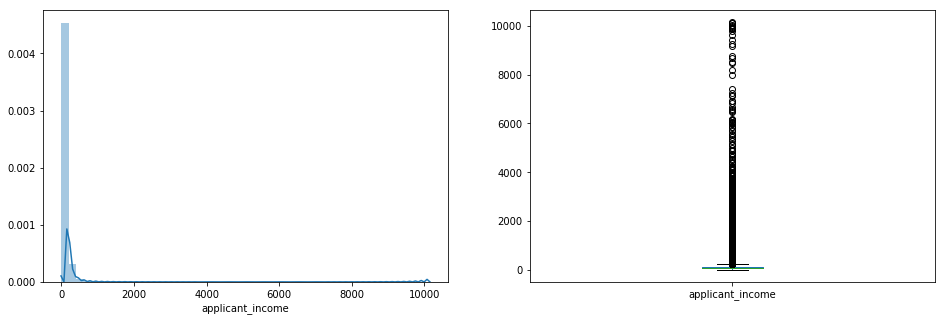

In [121]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train1['applicant_income']); 
plt.subplot(122)
train1['applicant_income'].plot.box(figsize=(16,5)) 
plt.show()

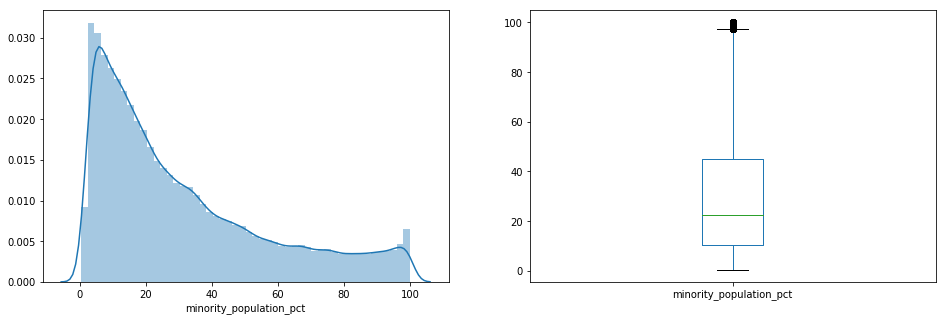

In [122]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train1['minority_population_pct']); 
plt.subplot(122)
train1['minority_population_pct'].plot.box(figsize=(16,5)) 
plt.show()

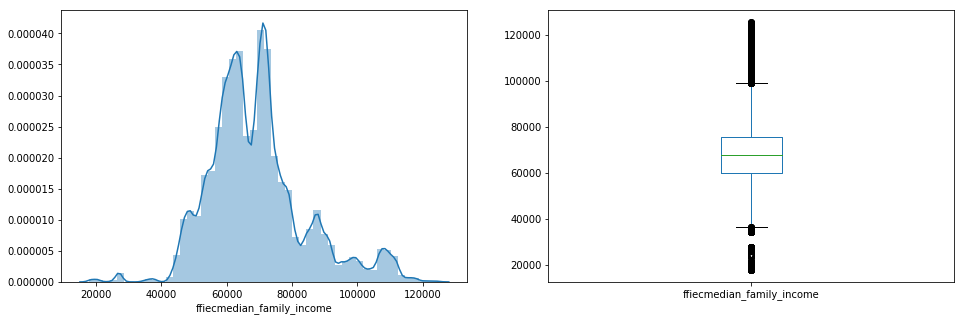

In [123]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train1['ffiecmedian_family_income']); 
plt.subplot(122)
train1['ffiecmedian_family_income'].plot.box(figsize=(16,5)) 
plt.show()

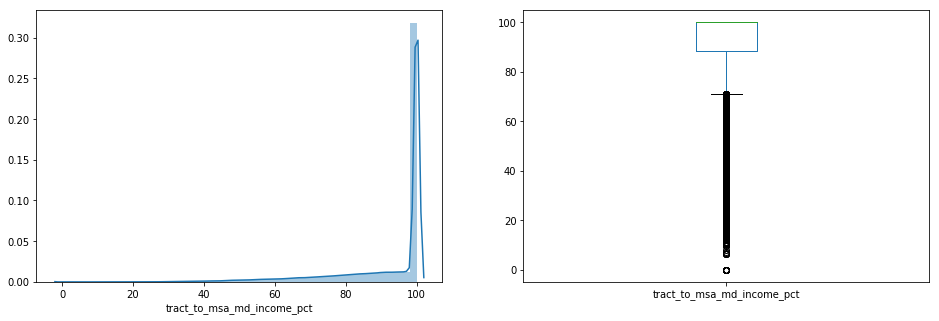

In [124]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train1['tract_to_msa_md_income_pct']); 
plt.subplot(122)
train1['tract_to_msa_md_income_pct'].plot.box(figsize=(16,5))  
plt.show()

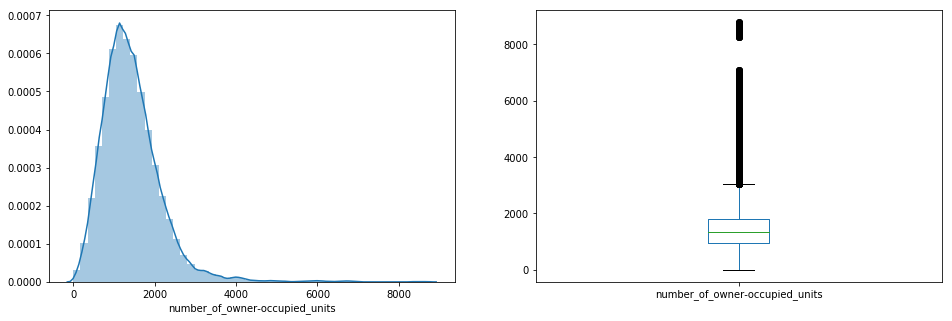

In [125]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train1['number_of_owner-occupied_units']); 
plt.subplot(122)
train1['number_of_owner-occupied_units'].plot.box(figsize=(16,5)) 
plt.show()

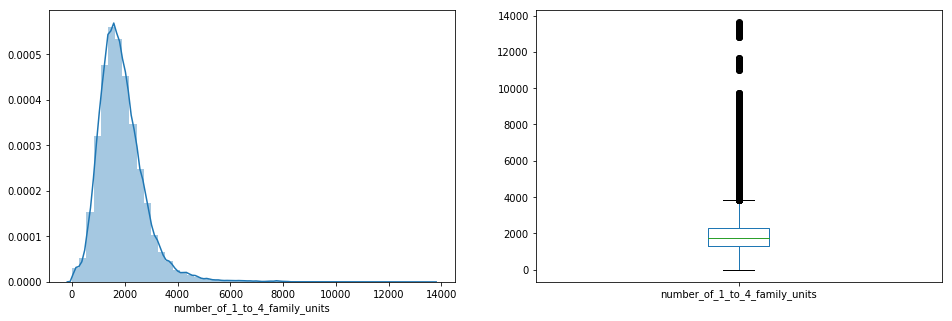

In [126]:
plt.figure(1) 
plt.subplot(121)
sns.distplot(train1['number_of_1_to_4_family_units']); 
plt.subplot(122)
train1['number_of_1_to_4_family_units'].plot.box(figsize=(16,5)) 
plt.show()

### Bivariate Analysis

#### Categorical Independent Variable vs Target Variable

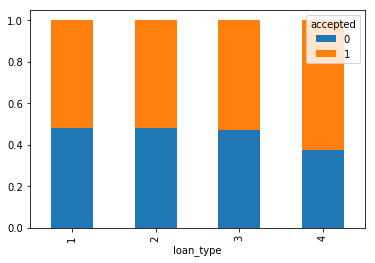

In [127]:
loan_type=pd.crosstab(train1['loan_type'],train1['accepted'])
loan_type.div(loan_type.sum(1).astype(float),
              axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

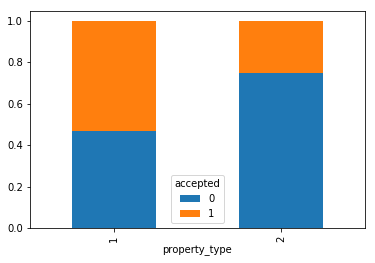

In [128]:
property_type=pd.crosstab(train1['property_type'],train1['accepted'])
property_type.div(property_type.sum(1).astype(float),
                  axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

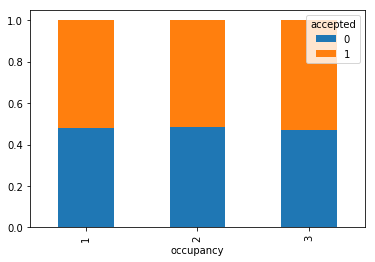

In [129]:
occupancy=pd.crosstab(train1['occupancy'],train1['accepted'])
occupancy.div(occupancy.sum(1).astype(float),
              axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

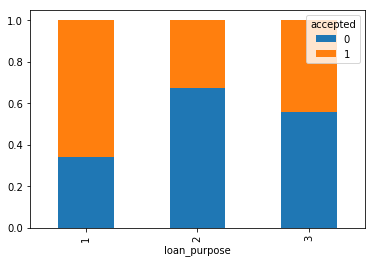

In [130]:
loan_purpose=pd.crosstab(train1['loan_purpose'],train1['accepted'])
loan_purpose.div(loan_purpose.sum(1).astype(float), 
                 axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

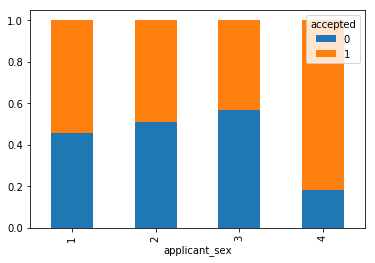

In [131]:
applicant_sex=pd.crosstab(train1['applicant_sex'],train1['accepted'])
applicant_sex.div(applicant_sex.sum(1).astype(float),
                  axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

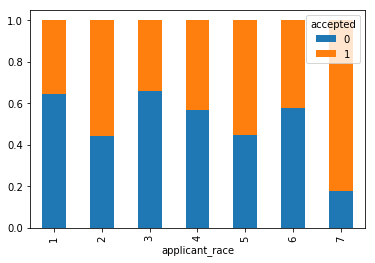

In [132]:
applicant_race=pd.crosstab(train1['applicant_race'],train1['accepted'])
applicant_race.div(applicant_race.sum(1).astype(float),
                   axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

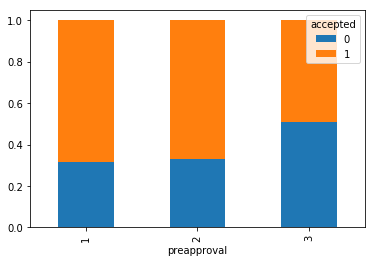

In [133]:
preapproval=pd.crosstab(train1['preapproval'],train1['accepted'])
preapproval.div(preapproval.sum(1).astype(float),
                axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

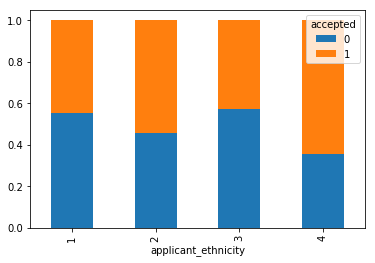

In [134]:
applicant_ethnicity=pd.crosstab(train1['applicant_ethnicity'],train1['accepted'])
applicant_ethnicity.div(applicant_ethnicity.sum(1).astype(float),
                        axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

### Numerical Independent Variable vs Target Variable

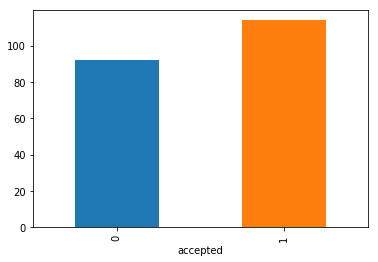

In [135]:
train1.groupby('accepted')['applicant_income'].mean().plot.bar()

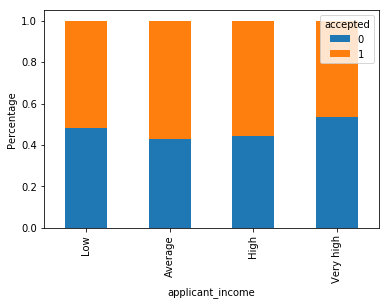

In [136]:
bins=[0,1500,4000,6000,10139] 
group=['Low','Average','High', 'Very high'] 

train1['Income_bin']=pd.cut(train1['applicant_income'],bins,labels=group)

Income_bin=pd.crosstab(train1['Income_bin'],train1['accepted'])

Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

plt.xlabel('applicant_income') 
P = plt.ylabel('Percentage')

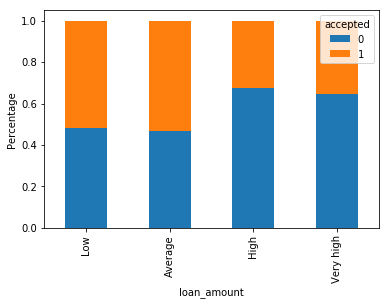

In [137]:
bins=[0,1500,4000,6000,15983] 
group=['Low','Average','High', 'Very high'] 

train1['loan_amount_bin']=pd.cut(train1['loan_amount'],bins,labels=group)

loan_amount_bin=pd.crosstab(train1['loan_amount_bin'],train1['accepted'])

loan_amount_bin.div(loan_amount_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

plt.xlabel('loan_amount') 
P = plt.ylabel('Percentage')

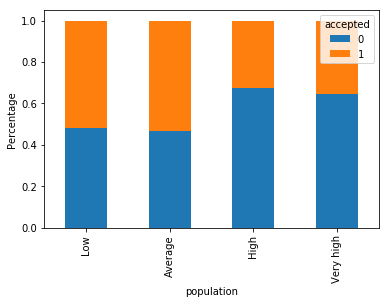

In [138]:
bins=[0,8000,15000,25000,40000] 
group=['Low','Average','High', 'Very high'] 

train1['population_pop_bin']=pd.cut(train1['population'],bins,labels=group)

population_pop_bin=pd.crosstab(train1['loan_amount_bin'],train1['accepted'])

population_pop_bin.div(population_pop_bin.sum(1).astype(float),
                       axis=0).plot(kind="bar", stacked=True)

plt.xlabel('population') 
P = plt.ylabel('Percentage')

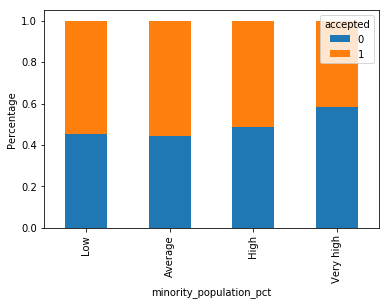

In [139]:
bins=[0,15,30,60,100] 
group=['Low','Average','High', 'Very high'] 

train1['min_pop_bin']=pd.cut(train1['minority_population_pct'],bins,labels=group)

Income_bin=pd.crosstab(train1['min_pop_bin'],train1['accepted'])

Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

plt.xlabel('minority_population_pct') 
P = plt.ylabel('Percentage')

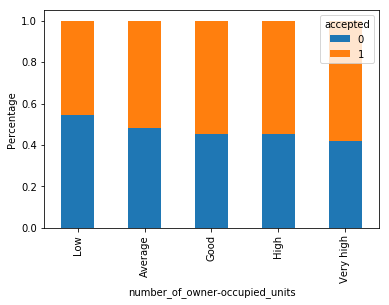

In [140]:
bins=[0,500, 2000,3500,5000,10000] 
group=['Low','Average','Good','High', 'Very high'] 

train1['num_own_bin']=pd.cut(train1['number_of_owner-occupied_units'],bins,labels=group)

Income_bin=pd.crosstab(train1['num_own_bin'],train1['accepted'])

Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

plt.xlabel('number_of_owner-occupied_units') 
P = plt.ylabel('Percentage')

It can be inferred that Applicant income does not affect the chances of loan approval which contradicts our hypothesis in which we assumed that if the applicant income is high the chances of loan approval will also be high.

In [141]:
# Basic correlogram
#sns.pairplot(train1)
#sns.plt.show()

#pd.scatter_matrix(train1, figsize=(6, 6))
#plt.show()

### Dummy Variables Creation

In [142]:
X = pd.get_dummies(X) 
train = pd.get_dummies(train) 
test = pd.get_dummies(test)

In [143]:
numfeat = [ "loan_amount", "applicant_income", 
           "ffiecmedian_family_income",'population',
          'minority_population_pct','ffiecmedian_family_income','tract_to_msa_md_income_pct',
        'number_of_owner-occupied_units','number_of_1_to_4_family_units']

In [66]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
X[numfeat] = sc.fit_transform(X[numfeat])  
test[numfeat] = sc.fit_transform(test[numfeat]) 

In [144]:
catfeatures_index = np.where(X.dtypes != float)[0]

### MODELLING 

In [145]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y,test_size=0.3)

In [146]:
catboost = CatBoostClassifier(iterations=2000, depth=8, 
                              learning_rate=0.05,                           
                           eval_metric='Accuracy',use_best_model=True, random_seed=44624)

In [147]:
catboost.fit(X_train, y_train, cat_features = catfeatures_index, eval_set = (X_cv, y_cv)) #Model training


0:	learn: 0.6940114	test: 0.6961600	best: 0.6961600 (0)	total: 542ms	remaining: 18m 3s
1:	learn: 0.6981286	test: 0.7006267	best: 0.7006267 (1)	total: 923ms	remaining: 15m 22s
2:	learn: 0.6969771	test: 0.6990600	best: 0.7006267 (1)	total: 1.29s	remaining: 14m 20s
3:	learn: 0.6987914	test: 0.7009067	best: 0.7009067 (3)	total: 1.66s	remaining: 13m 47s
4:	learn: 0.6993029	test: 0.7015467	best: 0.7015467 (4)	total: 2.04s	remaining: 13m 33s
5:	learn: 0.6999914	test: 0.7024933	best: 0.7024933 (5)	total: 2.41s	remaining: 13m 22s
6:	learn: 0.7003629	test: 0.7020800	best: 0.7024933 (5)	total: 2.81s	remaining: 13m 18s
7:	learn: 0.7011143	test: 0.7032600	best: 0.7032600 (7)	total: 3.18s	remaining: 13m 11s
8:	learn: 0.7015714	test: 0.7040400	best: 0.7040400 (8)	total: 3.58s	remaining: 13m 12s
9:	learn: 0.7029514	test: 0.7057467	best: 0.7057467 (9)	total: 3.99s	remaining: 13m 14s
10:	learn: 0.7031943	test: 0.7058400	best: 0.7058400 (10)	total: 4.36s	remaining: 13m 8s
11:	learn: 0.7036800	test: 0.706

92:	learn: 0.7189114	test: 0.7209800	best: 0.7209800 (92)	total: 37.3s	remaining: 12m 45s
93:	learn: 0.7189286	test: 0.7209400	best: 0.7209800 (92)	total: 37.7s	remaining: 12m 45s
94:	learn: 0.7189743	test: 0.7208467	best: 0.7209800 (92)	total: 38.2s	remaining: 12m 45s
95:	learn: 0.7191771	test: 0.7210600	best: 0.7210600 (95)	total: 38.5s	remaining: 12m 44s
96:	learn: 0.7193057	test: 0.7210267	best: 0.7210600 (95)	total: 39s	remaining: 12m 44s
97:	learn: 0.7194800	test: 0.7211533	best: 0.7211533 (97)	total: 39.4s	remaining: 12m 45s
98:	learn: 0.7195686	test: 0.7211333	best: 0.7211533 (97)	total: 39.9s	remaining: 12m 45s
99:	learn: 0.7195743	test: 0.7213400	best: 0.7213400 (99)	total: 40.3s	remaining: 12m 44s
100:	learn: 0.7196143	test: 0.7213733	best: 0.7213733 (100)	total: 40.6s	remaining: 12m 44s
101:	learn: 0.7196829	test: 0.7215000	best: 0.7215000 (101)	total: 41s	remaining: 12m 43s
102:	learn: 0.7197114	test: 0.7214733	best: 0.7215000 (101)	total: 41.5s	remaining: 12m 43s
103:	lea

182:	learn: 0.7234629	test: 0.7236533	best: 0.7236533 (182)	total: 1m 14s	remaining: 12m 20s
183:	learn: 0.7235343	test: 0.7235133	best: 0.7236533 (182)	total: 1m 15s	remaining: 12m 20s
184:	learn: 0.7235571	test: 0.7235467	best: 0.7236533 (182)	total: 1m 15s	remaining: 12m 20s
185:	learn: 0.7235971	test: 0.7236067	best: 0.7236533 (182)	total: 1m 15s	remaining: 12m 19s
186:	learn: 0.7236514	test: 0.7236267	best: 0.7236533 (182)	total: 1m 16s	remaining: 12m 19s
187:	learn: 0.7236743	test: 0.7238200	best: 0.7238200 (187)	total: 1m 16s	remaining: 12m 19s
188:	learn: 0.7236943	test: 0.7237733	best: 0.7238200 (187)	total: 1m 17s	remaining: 12m 19s
189:	learn: 0.7237057	test: 0.7238333	best: 0.7238333 (189)	total: 1m 17s	remaining: 12m 19s
190:	learn: 0.7237486	test: 0.7237267	best: 0.7238333 (189)	total: 1m 18s	remaining: 12m 19s
191:	learn: 0.7238143	test: 0.7237600	best: 0.7238333 (189)	total: 1m 18s	remaining: 12m 18s
192:	learn: 0.7238257	test: 0.7237133	best: 0.7238333 (189)	total: 1m 

271:	learn: 0.7261686	test: 0.7250733	best: 0.7251333 (269)	total: 1m 51s	remaining: 11m 49s
272:	learn: 0.7262257	test: 0.7250333	best: 0.7251333 (269)	total: 1m 52s	remaining: 11m 49s
273:	learn: 0.7262943	test: 0.7251333	best: 0.7251333 (269)	total: 1m 52s	remaining: 11m 48s
274:	learn: 0.7262800	test: 0.7250933	best: 0.7251333 (269)	total: 1m 52s	remaining: 11m 48s
275:	learn: 0.7263657	test: 0.7250400	best: 0.7251333 (269)	total: 1m 53s	remaining: 11m 48s
276:	learn: 0.7263714	test: 0.7250933	best: 0.7251333 (269)	total: 1m 53s	remaining: 11m 48s
277:	learn: 0.7264229	test: 0.7251667	best: 0.7251667 (277)	total: 1m 54s	remaining: 11m 47s
278:	learn: 0.7264657	test: 0.7251800	best: 0.7251800 (278)	total: 1m 54s	remaining: 11m 47s
279:	learn: 0.7264914	test: 0.7251733	best: 0.7251800 (278)	total: 1m 55s	remaining: 11m 47s
280:	learn: 0.7265000	test: 0.7251667	best: 0.7251800 (278)	total: 1m 55s	remaining: 11m 46s
281:	learn: 0.7265371	test: 0.7252133	best: 0.7252133 (281)	total: 1m 

360:	learn: 0.7289771	test: 0.7258200	best: 0.7259600 (353)	total: 2m 29s	remaining: 11m 17s
361:	learn: 0.7289457	test: 0.7258067	best: 0.7259600 (353)	total: 2m 29s	remaining: 11m 17s
362:	learn: 0.7289857	test: 0.7258933	best: 0.7259600 (353)	total: 2m 30s	remaining: 11m 17s
363:	learn: 0.7290229	test: 0.7260333	best: 0.7260333 (363)	total: 2m 30s	remaining: 11m 16s
364:	learn: 0.7289629	test: 0.7261067	best: 0.7261067 (364)	total: 2m 31s	remaining: 11m 16s
365:	learn: 0.7290171	test: 0.7261600	best: 0.7261600 (365)	total: 2m 31s	remaining: 11m 16s
366:	learn: 0.7290886	test: 0.7261667	best: 0.7261667 (366)	total: 2m 31s	remaining: 11m 15s
367:	learn: 0.7290886	test: 0.7261533	best: 0.7261667 (366)	total: 2m 32s	remaining: 11m 15s
368:	learn: 0.7291400	test: 0.7261133	best: 0.7261667 (366)	total: 2m 32s	remaining: 11m 15s
369:	learn: 0.7291714	test: 0.7261200	best: 0.7261667 (366)	total: 2m 33s	remaining: 11m 14s
370:	learn: 0.7291657	test: 0.7260800	best: 0.7261667 (366)	total: 2m 

449:	learn: 0.7312114	test: 0.7261800	best: 0.7264200 (410)	total: 3m 7s	remaining: 10m 44s
450:	learn: 0.7312657	test: 0.7262067	best: 0.7264200 (410)	total: 3m 7s	remaining: 10m 44s
451:	learn: 0.7312771	test: 0.7262867	best: 0.7264200 (410)	total: 3m 7s	remaining: 10m 43s
452:	learn: 0.7313029	test: 0.7263000	best: 0.7264200 (410)	total: 3m 8s	remaining: 10m 43s
453:	learn: 0.7313086	test: 0.7263067	best: 0.7264200 (410)	total: 3m 8s	remaining: 10m 43s
454:	learn: 0.7313314	test: 0.7263400	best: 0.7264200 (410)	total: 3m 9s	remaining: 10m 42s
455:	learn: 0.7313629	test: 0.7263000	best: 0.7264200 (410)	total: 3m 9s	remaining: 10m 42s
456:	learn: 0.7313914	test: 0.7263400	best: 0.7264200 (410)	total: 3m 10s	remaining: 10m 42s
457:	learn: 0.7314057	test: 0.7263333	best: 0.7264200 (410)	total: 3m 10s	remaining: 10m 41s
458:	learn: 0.7314229	test: 0.7263933	best: 0.7264200 (410)	total: 3m 11s	remaining: 10m 41s
459:	learn: 0.7314400	test: 0.7264267	best: 0.7264267 (459)	total: 3m 11s	rem

538:	learn: 0.7331000	test: 0.7271000	best: 0.7271133 (526)	total: 3m 44s	remaining: 10m 9s
539:	learn: 0.7331429	test: 0.7271067	best: 0.7271133 (526)	total: 3m 45s	remaining: 10m 8s
540:	learn: 0.7331914	test: 0.7270867	best: 0.7271133 (526)	total: 3m 45s	remaining: 10m 8s
541:	learn: 0.7331771	test: 0.7270533	best: 0.7271133 (526)	total: 3m 45s	remaining: 10m 7s
542:	learn: 0.7331971	test: 0.7271200	best: 0.7271200 (542)	total: 3m 46s	remaining: 10m 7s
543:	learn: 0.7331914	test: 0.7271533	best: 0.7271533 (543)	total: 3m 46s	remaining: 10m 7s
544:	learn: 0.7332400	test: 0.7271467	best: 0.7271533 (543)	total: 3m 47s	remaining: 10m 6s
545:	learn: 0.7332629	test: 0.7271667	best: 0.7271667 (545)	total: 3m 47s	remaining: 10m 6s
546:	learn: 0.7333000	test: 0.7271467	best: 0.7271667 (545)	total: 3m 48s	remaining: 10m 5s
547:	learn: 0.7333029	test: 0.7271733	best: 0.7271733 (547)	total: 3m 48s	remaining: 10m 5s
548:	learn: 0.7332714	test: 0.7271933	best: 0.7271933 (548)	total: 3m 48s	remain

628:	learn: 0.7346971	test: 0.7279467	best: 0.7279467 (628)	total: 4m 22s	remaining: 9m 33s
629:	learn: 0.7346829	test: 0.7279533	best: 0.7279533 (629)	total: 4m 23s	remaining: 9m 32s
630:	learn: 0.7347429	test: 0.7279933	best: 0.7279933 (630)	total: 4m 23s	remaining: 9m 32s
631:	learn: 0.7347686	test: 0.7280000	best: 0.7280000 (631)	total: 4m 24s	remaining: 9m 31s
632:	learn: 0.7347257	test: 0.7279133	best: 0.7280000 (631)	total: 4m 24s	remaining: 9m 31s
633:	learn: 0.7347629	test: 0.7279000	best: 0.7280000 (631)	total: 4m 25s	remaining: 9m 31s
634:	learn: 0.7348200	test: 0.7278867	best: 0.7280000 (631)	total: 4m 25s	remaining: 9m 30s
635:	learn: 0.7348314	test: 0.7279200	best: 0.7280000 (631)	total: 4m 25s	remaining: 9m 30s
636:	learn: 0.7348514	test: 0.7279333	best: 0.7280000 (631)	total: 4m 26s	remaining: 9m 29s
637:	learn: 0.7348229	test: 0.7279333	best: 0.7280000 (631)	total: 4m 26s	remaining: 9m 29s
638:	learn: 0.7348371	test: 0.7279533	best: 0.7280000 (631)	total: 4m 27s	remain

718:	learn: 0.7363914	test: 0.7279333	best: 0.7280867 (679)	total: 5m 1s	remaining: 8m 57s
719:	learn: 0.7364714	test: 0.7279200	best: 0.7280867 (679)	total: 5m 1s	remaining: 8m 56s
720:	learn: 0.7365143	test: 0.7279333	best: 0.7280867 (679)	total: 5m 2s	remaining: 8m 56s
721:	learn: 0.7365457	test: 0.7279133	best: 0.7280867 (679)	total: 5m 2s	remaining: 8m 55s
722:	learn: 0.7365400	test: 0.7278800	best: 0.7280867 (679)	total: 5m 3s	remaining: 8m 55s
723:	learn: 0.7365400	test: 0.7278600	best: 0.7280867 (679)	total: 5m 3s	remaining: 8m 55s
724:	learn: 0.7365714	test: 0.7278667	best: 0.7280867 (679)	total: 5m 4s	remaining: 8m 54s
725:	learn: 0.7365857	test: 0.7278400	best: 0.7280867 (679)	total: 5m 4s	remaining: 8m 54s
726:	learn: 0.7366543	test: 0.7278000	best: 0.7280867 (679)	total: 5m 4s	remaining: 8m 53s
727:	learn: 0.7366457	test: 0.7278600	best: 0.7280867 (679)	total: 5m 5s	remaining: 8m 53s
728:	learn: 0.7366600	test: 0.7278400	best: 0.7280867 (679)	total: 5m 5s	remaining: 8m 53s

808:	learn: 0.7382057	test: 0.7284067	best: 0.7284067 (808)	total: 5m 39s	remaining: 8m 20s
809:	learn: 0.7382571	test: 0.7283267	best: 0.7284067 (808)	total: 5m 40s	remaining: 8m 19s
810:	learn: 0.7382286	test: 0.7283067	best: 0.7284067 (808)	total: 5m 40s	remaining: 8m 19s
811:	learn: 0.7382686	test: 0.7283667	best: 0.7284067 (808)	total: 5m 41s	remaining: 8m 19s
812:	learn: 0.7382657	test: 0.7283667	best: 0.7284067 (808)	total: 5m 41s	remaining: 8m 18s
813:	learn: 0.7383086	test: 0.7283067	best: 0.7284067 (808)	total: 5m 42s	remaining: 8m 18s
814:	learn: 0.7382829	test: 0.7282400	best: 0.7284067 (808)	total: 5m 42s	remaining: 8m 17s
815:	learn: 0.7383086	test: 0.7282067	best: 0.7284067 (808)	total: 5m 42s	remaining: 8m 17s
816:	learn: 0.7383486	test: 0.7281867	best: 0.7284067 (808)	total: 5m 43s	remaining: 8m 17s
817:	learn: 0.7383400	test: 0.7282267	best: 0.7284067 (808)	total: 5m 43s	remaining: 8m 16s
818:	learn: 0.7383857	test: 0.7282533	best: 0.7284067 (808)	total: 5m 44s	remain

898:	learn: 0.7398257	test: 0.7281200	best: 0.7284333 (845)	total: 6m 18s	remaining: 7m 43s
899:	learn: 0.7398257	test: 0.7281067	best: 0.7284333 (845)	total: 6m 19s	remaining: 7m 43s
900:	learn: 0.7398400	test: 0.7281600	best: 0.7284333 (845)	total: 6m 19s	remaining: 7m 43s
901:	learn: 0.7398200	test: 0.7281667	best: 0.7284333 (845)	total: 6m 20s	remaining: 7m 42s
902:	learn: 0.7398286	test: 0.7282000	best: 0.7284333 (845)	total: 6m 20s	remaining: 7m 42s
903:	learn: 0.7398771	test: 0.7281400	best: 0.7284333 (845)	total: 6m 20s	remaining: 7m 41s
904:	learn: 0.7398629	test: 0.7281867	best: 0.7284333 (845)	total: 6m 21s	remaining: 7m 41s
905:	learn: 0.7398714	test: 0.7282067	best: 0.7284333 (845)	total: 6m 21s	remaining: 7m 40s
906:	learn: 0.7398829	test: 0.7281733	best: 0.7284333 (845)	total: 6m 22s	remaining: 7m 40s
907:	learn: 0.7398543	test: 0.7281267	best: 0.7284333 (845)	total: 6m 22s	remaining: 7m 40s
908:	learn: 0.7398886	test: 0.7281067	best: 0.7284333 (845)	total: 6m 22s	remain

988:	learn: 0.7410114	test: 0.7283200	best: 0.7284333 (845)	total: 6m 57s	remaining: 7m 7s
989:	learn: 0.7409714	test: 0.7283933	best: 0.7284333 (845)	total: 6m 58s	remaining: 7m 6s
990:	learn: 0.7410114	test: 0.7284400	best: 0.7284400 (990)	total: 6m 58s	remaining: 7m 6s
991:	learn: 0.7410029	test: 0.7284267	best: 0.7284400 (990)	total: 6m 59s	remaining: 7m 5s
992:	learn: 0.7410486	test: 0.7284267	best: 0.7284400 (990)	total: 6m 59s	remaining: 7m 5s
993:	learn: 0.7410657	test: 0.7284600	best: 0.7284600 (993)	total: 6m 59s	remaining: 7m 4s
994:	learn: 0.7410686	test: 0.7284600	best: 0.7284600 (993)	total: 7m	remaining: 7m 4s
995:	learn: 0.7410943	test: 0.7284333	best: 0.7284600 (993)	total: 7m	remaining: 7m 4s
996:	learn: 0.7410686	test: 0.7285000	best: 0.7285000 (996)	total: 7m 1s	remaining: 7m 3s
997:	learn: 0.7410800	test: 0.7285200	best: 0.7285200 (997)	total: 7m 1s	remaining: 7m 3s
998:	learn: 0.7410886	test: 0.7284800	best: 0.7285200 (997)	total: 7m 1s	remaining: 7m 2s
999:	learn

1077:	learn: 0.7424229	test: 0.7284667	best: 0.7286667 (1057)	total: 7m 34s	remaining: 6m 29s
1078:	learn: 0.7424286	test: 0.7285200	best: 0.7286667 (1057)	total: 7m 35s	remaining: 6m 28s
1079:	learn: 0.7424314	test: 0.7285067	best: 0.7286667 (1057)	total: 7m 35s	remaining: 6m 28s
1080:	learn: 0.7424486	test: 0.7284733	best: 0.7286667 (1057)	total: 7m 36s	remaining: 6m 27s
1081:	learn: 0.7424286	test: 0.7284933	best: 0.7286667 (1057)	total: 7m 36s	remaining: 6m 27s
1082:	learn: 0.7423857	test: 0.7285133	best: 0.7286667 (1057)	total: 7m 36s	remaining: 6m 26s
1083:	learn: 0.7424086	test: 0.7285400	best: 0.7286667 (1057)	total: 7m 37s	remaining: 6m 26s
1084:	learn: 0.7424743	test: 0.7286000	best: 0.7286667 (1057)	total: 7m 37s	remaining: 6m 26s
1085:	learn: 0.7424743	test: 0.7286667	best: 0.7286667 (1057)	total: 7m 38s	remaining: 6m 25s
1086:	learn: 0.7425086	test: 0.7285733	best: 0.7286667 (1057)	total: 7m 38s	remaining: 6m 25s
1087:	learn: 0.7425229	test: 0.7285400	best: 0.7286667 (1057

1165:	learn: 0.7435486	test: 0.7284000	best: 0.7286667 (1057)	total: 8m 12s	remaining: 5m 51s
1166:	learn: 0.7435714	test: 0.7284467	best: 0.7286667 (1057)	total: 8m 12s	remaining: 5m 51s
1167:	learn: 0.7435971	test: 0.7283467	best: 0.7286667 (1057)	total: 8m 12s	remaining: 5m 51s
1168:	learn: 0.7436114	test: 0.7283800	best: 0.7286667 (1057)	total: 8m 13s	remaining: 5m 50s
1169:	learn: 0.7436543	test: 0.7283400	best: 0.7286667 (1057)	total: 8m 13s	remaining: 5m 50s
1170:	learn: 0.7436743	test: 0.7283000	best: 0.7286667 (1057)	total: 8m 14s	remaining: 5m 49s
1171:	learn: 0.7436800	test: 0.7283733	best: 0.7286667 (1057)	total: 8m 14s	remaining: 5m 49s
1172:	learn: 0.7436943	test: 0.7283400	best: 0.7286667 (1057)	total: 8m 14s	remaining: 5m 48s
1173:	learn: 0.7437829	test: 0.7283667	best: 0.7286667 (1057)	total: 8m 15s	remaining: 5m 48s
1174:	learn: 0.7437829	test: 0.7283467	best: 0.7286667 (1057)	total: 8m 15s	remaining: 5m 48s
1175:	learn: 0.7438257	test: 0.7283800	best: 0.7286667 (1057

1253:	learn: 0.7448800	test: 0.7285400	best: 0.7286933 (1220)	total: 8m 49s	remaining: 5m 14s
1254:	learn: 0.7449114	test: 0.7284600	best: 0.7286933 (1220)	total: 8m 49s	remaining: 5m 14s
1255:	learn: 0.7449057	test: 0.7284867	best: 0.7286933 (1220)	total: 8m 50s	remaining: 5m 13s
1256:	learn: 0.7448771	test: 0.7284933	best: 0.7286933 (1220)	total: 8m 50s	remaining: 5m 13s
1257:	learn: 0.7449000	test: 0.7285533	best: 0.7286933 (1220)	total: 8m 50s	remaining: 5m 13s
1258:	learn: 0.7449057	test: 0.7285800	best: 0.7286933 (1220)	total: 8m 51s	remaining: 5m 12s
1259:	learn: 0.7449314	test: 0.7285533	best: 0.7286933 (1220)	total: 8m 51s	remaining: 5m 12s
1260:	learn: 0.7449429	test: 0.7285400	best: 0.7286933 (1220)	total: 8m 52s	remaining: 5m 11s
1261:	learn: 0.7449629	test: 0.7285600	best: 0.7286933 (1220)	total: 8m 52s	remaining: 5m 11s
1262:	learn: 0.7449486	test: 0.7285467	best: 0.7286933 (1220)	total: 8m 52s	remaining: 5m 11s
1263:	learn: 0.7449800	test: 0.7284800	best: 0.7286933 (1220

1341:	learn: 0.7461971	test: 0.7285933	best: 0.7287867 (1311)	total: 9m 26s	remaining: 4m 37s
1342:	learn: 0.7462400	test: 0.7286133	best: 0.7287867 (1311)	total: 9m 27s	remaining: 4m 37s
1343:	learn: 0.7462571	test: 0.7286533	best: 0.7287867 (1311)	total: 9m 27s	remaining: 4m 36s
1344:	learn: 0.7462171	test: 0.7286000	best: 0.7287867 (1311)	total: 9m 27s	remaining: 4m 36s
1345:	learn: 0.7462771	test: 0.7286133	best: 0.7287867 (1311)	total: 9m 28s	remaining: 4m 36s
1346:	learn: 0.7462886	test: 0.7286200	best: 0.7287867 (1311)	total: 9m 28s	remaining: 4m 35s
1347:	learn: 0.7462943	test: 0.7286467	best: 0.7287867 (1311)	total: 9m 29s	remaining: 4m 35s
1348:	learn: 0.7463029	test: 0.7286267	best: 0.7287867 (1311)	total: 9m 29s	remaining: 4m 34s
1349:	learn: 0.7463114	test: 0.7286333	best: 0.7287867 (1311)	total: 9m 29s	remaining: 4m 34s
1350:	learn: 0.7463314	test: 0.7286333	best: 0.7287867 (1311)	total: 9m 30s	remaining: 4m 34s
1351:	learn: 0.7463714	test: 0.7285867	best: 0.7287867 (1311

1429:	learn: 0.7474857	test: 0.7285800	best: 0.7287867 (1311)	total: 10m 4s	remaining: 4m
1430:	learn: 0.7474971	test: 0.7285933	best: 0.7287867 (1311)	total: 10m 4s	remaining: 4m
1431:	learn: 0.7474971	test: 0.7285933	best: 0.7287867 (1311)	total: 10m 5s	remaining: 4m
1432:	learn: 0.7474914	test: 0.7286067	best: 0.7287867 (1311)	total: 10m 5s	remaining: 3m 59s
1433:	learn: 0.7475257	test: 0.7286200	best: 0.7287867 (1311)	total: 10m 6s	remaining: 3m 59s
1434:	learn: 0.7475171	test: 0.7286200	best: 0.7287867 (1311)	total: 10m 6s	remaining: 3m 58s
1435:	learn: 0.7475571	test: 0.7285667	best: 0.7287867 (1311)	total: 10m 7s	remaining: 3m 58s
1436:	learn: 0.7475657	test: 0.7285600	best: 0.7287867 (1311)	total: 10m 7s	remaining: 3m 58s
1437:	learn: 0.7475171	test: 0.7285267	best: 0.7287867 (1311)	total: 10m 7s	remaining: 3m 57s
1438:	learn: 0.7475200	test: 0.7285800	best: 0.7287867 (1311)	total: 10m 8s	remaining: 3m 57s
1439:	learn: 0.7475286	test: 0.7286400	best: 0.7287867 (1311)	total: 10m

1516:	learn: 0.7484400	test: 0.7285467	best: 0.7287867 (1311)	total: 10m 42s	remaining: 3m 24s
1517:	learn: 0.7484343	test: 0.7285933	best: 0.7287867 (1311)	total: 10m 42s	remaining: 3m 24s
1518:	learn: 0.7484629	test: 0.7285933	best: 0.7287867 (1311)	total: 10m 42s	remaining: 3m 23s
1519:	learn: 0.7484343	test: 0.7285800	best: 0.7287867 (1311)	total: 10m 43s	remaining: 3m 23s
1520:	learn: 0.7484657	test: 0.7286067	best: 0.7287867 (1311)	total: 10m 43s	remaining: 3m 22s
1521:	learn: 0.7484771	test: 0.7286467	best: 0.7287867 (1311)	total: 10m 44s	remaining: 3m 22s
1522:	learn: 0.7484857	test: 0.7286733	best: 0.7287867 (1311)	total: 10m 44s	remaining: 3m 21s
1523:	learn: 0.7485171	test: 0.7286867	best: 0.7287867 (1311)	total: 10m 45s	remaining: 3m 21s
1524:	learn: 0.7485286	test: 0.7287000	best: 0.7287867 (1311)	total: 10m 45s	remaining: 3m 21s
1525:	learn: 0.7485600	test: 0.7286800	best: 0.7287867 (1311)	total: 10m 46s	remaining: 3m 20s
1526:	learn: 0.7485743	test: 0.7286600	best: 0.728

1603:	learn: 0.7497571	test: 0.7285533	best: 0.7287867 (1311)	total: 11m 19s	remaining: 2m 47s
1604:	learn: 0.7497686	test: 0.7285867	best: 0.7287867 (1311)	total: 11m 20s	remaining: 2m 47s
1605:	learn: 0.7497829	test: 0.7285933	best: 0.7287867 (1311)	total: 11m 20s	remaining: 2m 47s
1606:	learn: 0.7497714	test: 0.7285667	best: 0.7287867 (1311)	total: 11m 21s	remaining: 2m 46s
1607:	learn: 0.7498057	test: 0.7285400	best: 0.7287867 (1311)	total: 11m 21s	remaining: 2m 46s
1608:	learn: 0.7498629	test: 0.7285533	best: 0.7287867 (1311)	total: 11m 22s	remaining: 2m 45s
1609:	learn: 0.7498486	test: 0.7285733	best: 0.7287867 (1311)	total: 11m 22s	remaining: 2m 45s
1610:	learn: 0.7498971	test: 0.7286067	best: 0.7287867 (1311)	total: 11m 23s	remaining: 2m 44s
1611:	learn: 0.7499371	test: 0.7285867	best: 0.7287867 (1311)	total: 11m 23s	remaining: 2m 44s
1612:	learn: 0.7499486	test: 0.7286400	best: 0.7287867 (1311)	total: 11m 23s	remaining: 2m 44s
1613:	learn: 0.7499629	test: 0.7286467	best: 0.728

1690:	learn: 0.7511400	test: 0.7288333	best: 0.7289067 (1687)	total: 11m 58s	remaining: 2m 11s
1691:	learn: 0.7511629	test: 0.7288333	best: 0.7289067 (1687)	total: 11m 58s	remaining: 2m 10s
1692:	learn: 0.7511600	test: 0.7288133	best: 0.7289067 (1687)	total: 11m 59s	remaining: 2m 10s
1693:	learn: 0.7511486	test: 0.7288400	best: 0.7289067 (1687)	total: 11m 59s	remaining: 2m 9s
1694:	learn: 0.7511571	test: 0.7288467	best: 0.7289067 (1687)	total: 12m	remaining: 2m 9s
1695:	learn: 0.7511457	test: 0.7288733	best: 0.7289067 (1687)	total: 12m	remaining: 2m 9s
1696:	learn: 0.7511514	test: 0.7288467	best: 0.7289067 (1687)	total: 12m 1s	remaining: 2m 8s
1697:	learn: 0.7511857	test: 0.7288400	best: 0.7289067 (1687)	total: 12m 1s	remaining: 2m 8s
1698:	learn: 0.7511600	test: 0.7288467	best: 0.7289067 (1687)	total: 12m 1s	remaining: 2m 7s
1699:	learn: 0.7511971	test: 0.7287933	best: 0.7289067 (1687)	total: 12m 2s	remaining: 2m 7s
1700:	learn: 0.7511714	test: 0.7287400	best: 0.7289067 (1687)	total: 

1777:	learn: 0.7522486	test: 0.7289067	best: 0.7289800 (1733)	total: 12m 36s	remaining: 1m 34s
1778:	learn: 0.7522543	test: 0.7288533	best: 0.7289800 (1733)	total: 12m 36s	remaining: 1m 34s
1779:	learn: 0.7522400	test: 0.7288133	best: 0.7289800 (1733)	total: 12m 37s	remaining: 1m 33s
1780:	learn: 0.7522714	test: 0.7287600	best: 0.7289800 (1733)	total: 12m 37s	remaining: 1m 33s
1781:	learn: 0.7523171	test: 0.7287667	best: 0.7289800 (1733)	total: 12m 38s	remaining: 1m 32s
1782:	learn: 0.7523314	test: 0.7287733	best: 0.7289800 (1733)	total: 12m 38s	remaining: 1m 32s
1783:	learn: 0.7523629	test: 0.7287800	best: 0.7289800 (1733)	total: 12m 39s	remaining: 1m 31s
1784:	learn: 0.7524000	test: 0.7288000	best: 0.7289800 (1733)	total: 12m 39s	remaining: 1m 31s
1785:	learn: 0.7523943	test: 0.7288000	best: 0.7289800 (1733)	total: 12m 39s	remaining: 1m 31s
1786:	learn: 0.7524029	test: 0.7288333	best: 0.7289800 (1733)	total: 12m 40s	remaining: 1m 30s
1787:	learn: 0.7524171	test: 0.7288333	best: 0.728

1864:	learn: 0.7535114	test: 0.7290533	best: 0.7290533 (1864)	total: 13m 14s	remaining: 57.5s
1865:	learn: 0.7535200	test: 0.7290533	best: 0.7290533 (1864)	total: 13m 15s	remaining: 57.1s
1866:	learn: 0.7535457	test: 0.7290467	best: 0.7290533 (1864)	total: 13m 15s	remaining: 56.7s
1867:	learn: 0.7535600	test: 0.7290000	best: 0.7290533 (1864)	total: 13m 16s	remaining: 56.3s
1868:	learn: 0.7535971	test: 0.7290733	best: 0.7290733 (1868)	total: 13m 16s	remaining: 55.8s
1869:	learn: 0.7536086	test: 0.7290800	best: 0.7290800 (1869)	total: 13m 17s	remaining: 55.4s
1870:	learn: 0.7536286	test: 0.7290800	best: 0.7290800 (1869)	total: 13m 17s	remaining: 55s
1871:	learn: 0.7536629	test: 0.7290800	best: 0.7290800 (1869)	total: 13m 17s	remaining: 54.6s
1872:	learn: 0.7536657	test: 0.7290867	best: 0.7290867 (1872)	total: 13m 18s	remaining: 54.1s
1873:	learn: 0.7536800	test: 0.7290467	best: 0.7290867 (1872)	total: 13m 18s	remaining: 53.7s
1874:	learn: 0.7537200	test: 0.7290533	best: 0.7290867 (1872)	

1952:	learn: 0.7547343	test: 0.7289200	best: 0.7290867 (1872)	total: 13m 53s	remaining: 20.1s
1953:	learn: 0.7547571	test: 0.7288467	best: 0.7290867 (1872)	total: 13m 53s	remaining: 19.6s
1954:	learn: 0.7547343	test: 0.7289067	best: 0.7290867 (1872)	total: 13m 54s	remaining: 19.2s
1955:	learn: 0.7547543	test: 0.7288867	best: 0.7290867 (1872)	total: 13m 54s	remaining: 18.8s
1956:	learn: 0.7547657	test: 0.7289400	best: 0.7290867 (1872)	total: 13m 55s	remaining: 18.3s
1957:	learn: 0.7547800	test: 0.7289533	best: 0.7290867 (1872)	total: 13m 55s	remaining: 17.9s
1958:	learn: 0.7547743	test: 0.7289200	best: 0.7290867 (1872)	total: 13m 55s	remaining: 17.5s
1959:	learn: 0.7547771	test: 0.7289400	best: 0.7290867 (1872)	total: 13m 56s	remaining: 17.1s
1960:	learn: 0.7547971	test: 0.7289133	best: 0.7290867 (1872)	total: 13m 56s	remaining: 16.6s
1961:	learn: 0.7548086	test: 0.7289200	best: 0.7290867 (1872)	total: 13m 57s	remaining: 16.2s
1962:	learn: 0.7548200	test: 0.7289600	best: 0.7290867 (1872

In [148]:
catboostpred = catboost.predict(X_cv)
catboostpredprobs = catboost.predict_proba(X_cv) # predicting probabilities

In [149]:
from sklearn.metrics import recall_score,confusion_matrix,precision_score, f1_score,roc_auc_score, roc_curve

In [150]:
print('the test accuracy is :{:.5f}'.format(accuracy_score(y_cv, catboostpred)))

the test accuracy is :0.72909


In [ ]:
pred = catboost.predict(test)
pred = pred.astype(np.int)

### Submission

In [ ]:
catboost_submission=pd.read_csv("submission_format.csv")

catboost_submission['accepted'] = pred

catboost_submission.to_csv('mondcatboost_submission.csv', index = False)

### Performance Checking

In [ ]:
print("Accuracy:",accuracy_score(catboostpred, y_cv)*100)
print()
print("Precision:",precision_score(catboostpred, y_cv)*100)
print()
#Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",recall_score(catboostpred, y_cv)*100)
print()
print("f1 score",f1_score(catboostpred, y_cv)*100)
print()
print("confusion matrix",confusion_matrix(catboostpred, y_cv))

### ROC

In [ ]:
# keep probabilities for the positive outcome only
probs = catboostpredprobs[:, 1]
# calculate AUC
auc = roc_auc_score(y_cv, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_cv, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()